https://www.kaggle.com/code/ahmedashrafhelmi/ecg-classification-rnn-gru-lstm

## Import libraries

In [1]:
import torch
from torch import nn, optim
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from common_utils import set_and_get_seed

SEED = set_and_get_seed()

## Exploratory Data Analysis

In [2]:
train_df = pd.read_csv('Heartbeat_Dataset/mitbih_train.csv')
test_df = pd.read_csv('Heartbeat_Dataset/mitbih_test.csv')

In [3]:
train_df.head()

,9.779411554336547852e-01,9.264705777168273926e-01,6.813725233078002930e-01,2.450980395078659058e-01,1.544117629528045654e-01,1.911764740943908691e-01,1.519607901573181152e-01,8.578431606292724609e-02,5.882352963089942932e-02,4.901960864663124084e-02,...,0.000000000000000000e+00.79,0.000000000000000000e+00.80,0.000000000000000000e+00.81,0.000000000000000000e+00.82,0.000000000000000000e+00.83,0.000000000000000000e+00.84,0.000000000000000000e+00.85,0.000000000000000000e+00.86,0.000000000000000000e+00.87,0.000000000000000000e+00.88
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
test_df.head()

,1.000000000000000000e+00,7.582644820213317871e-01,1.115702465176582336e-01,0.000000000000000000e+00,8.057851344347000122e-02,7.851240038871765137e-02,6.611569970846176147e-02,4.958677664399147034e-02,4.752065986394882202e-02,3.512396663427352905e-02,...,0.000000000000000000e+00.56,0.000000000000000000e+00.57,0.000000000000000000e+00.58,0.000000000000000000e+00.59,0.000000000000000000e+00.60,0.000000000000000000e+00.61,0.000000000000000000e+00.62,0.000000000000000000e+00.63,0.000000000000000000e+00.64,0.000000000000000000e+00.65
0,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.923664,0.656489,0.195929,0.111959,0.175573,0.122137,0.050891,0.035623,0.055980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It can be seen that the dataset does not have column and row names, hence we will set the header field in read_csv to None

In [5]:
train_df = pd.read_csv('Heartbeat_Dataset/mitbih_train.csv', header=None)
test_df = pd.read_csv('Heartbeat_Dataset/mitbih_test.csv', header=None)

In [6]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Check number of samples in datasets
print(f"Number of samples in train data: {train_df.shape[0]}, test data: {test_df.shape[0]}\n")

# Check distribution of classes in test and train sets
print("Train dataset class distribution")
print(train_df.iloc[:, -1].value_counts())
print("\nTest dataset class distribution")
print(test_df.iloc[:, -1].value_counts())

Number of samples in train data: 87554, test data: 21892

Train dataset class distribution
187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

Test dataset class distribution
187
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


In [9]:
# Labels for numbered categories
labels = {
    0.0: "N",
    1.0: "S",
    2.0: "V",
    3.0: "F",
    4.0: "Q"
}

C:\Users\User\AppData\Local\Temp\ipykernel_12096\2099662736.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sb.barplot(x=train_counts.index, y=train_counts.values, palette=colors)
C:\Users\User\AppData\Local\Temp\ipykernel_12096\2099662736.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{train_counts[i]}',


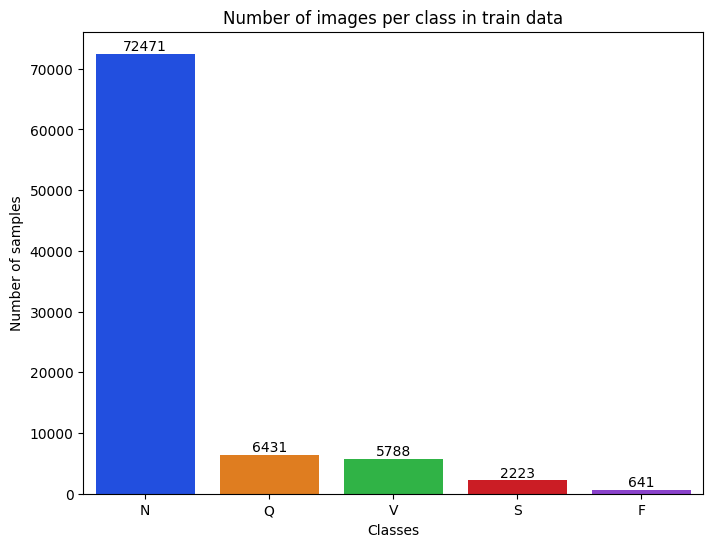

In [12]:
train_counts = train_df.iloc[:,-1].value_counts().rename(labels)

colors = sb.color_palette('bright', 5)
plt.figure(figsize=(8, 6))
ax = sb.barplot(x=train_counts.index, y=train_counts.values, palette=colors)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{train_counts[i]}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10)

plt.title('Number of images per class in train data')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_12096\2471494015.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sb.barplot(x=test_counts.index, y=test_counts.values, palette=colors)
C:\Users\User\AppData\Local\Temp\ipykernel_12096\2471494015.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{test_counts[i]}',


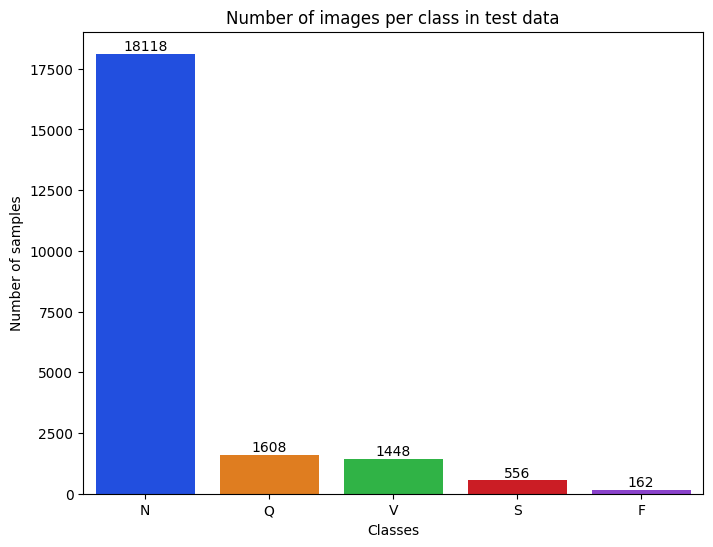

In [15]:
test_counts = test_df.iloc[:,-1].value_counts().rename(labels)

plt.figure(figsize=(8, 6))
ax = sb.barplot(x=test_counts.index, y=test_counts.values, palette=colors)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{test_counts[i]}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10)

plt.title('Number of images per class in test data')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.show()

## Preprocess dataset

We are not required to scale the dataset any further as the dataset has already been scaled

In [16]:
# Separate features and labels
X_train = train_df.iloc[:, :-1].values  # Exclude label
y_train = train_df.iloc[:, -1].values   # Labels

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

# Split the training data to obtain new train and validation sets
# Stratifying the split so both train and validation sets have same class distribution
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train)

print(f"New Training set: {X_train_new.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

New Training set: (70043, 187)
Validation set: (17511, 187)
Test set: (21892, 187)


In [17]:
# Reshape the data for RNN/LSTM/GRU (samples, timesteps, features), one feature per timestep
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train_new = np.reshape(X_train_new, (X_train_new.shape[0], X_train_new.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"New Training set size: {X_train_new.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")

New Training set size: (70043, 187, 1)
Validation set size: (17511, 187, 1)
Test set size: (21892, 187, 1)


## RNN Model

In [18]:
class RNNModel(nn.Module):
    def __init__(self, inputSize, hiddenSize, numLayers, numClasses):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(
            input_size = inputSize,
            hidden_size = hiddenSize,
            num_layers = numLayers,
            batch_first = True
        )

        self.fc = nn.Linear(hiddenSize, numClasses)
        return

    def forward(self, x):
        # Forward pass through RNN layers
        out, _ = self.rnn(x)

        # Use output from last timestep
        out = out[:, -1, :]

        # Pass output to fully connected layer
        out = self.fc(out)

        return out

In [19]:
# CONSTANTS
inputSize = 1
hiddenSize = 64
numClasses = 5
numLayers = 1
LEARNING_RATE = 0.001
EPOCHS = 25
BATCHSIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [20]:
# Instantiate model
rnn_model = RNNModel(inputSize, hiddenSize, numLayers, numClasses)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=LEARNING_RATE)

# Loss function
criterion = nn.CrossEntropyLoss()

In [21]:
# Prepare datasets in batches
from torch.utils.data import DataLoader, TensorDataset

# Create DataLoader for training and validation sets
def get_dataloaders(X_train, X_test, y_train, y_test):
    train_dataset = TensorDataset(torch.as_tensor(X_train, dtype=torch.float), torch.as_tensor(y_train, dtype=torch.float))
    val_dataset = TensorDataset(torch.as_tensor(X_test, dtype=torch.float), torch.as_tensor(y_test, dtype=torch.float))

    train_loader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
    test_loader = DataLoader(val_dataset, batch_size=BATCHSIZE)

    return train_loader, test_loader

In [22]:
def train_val(model, optimizer, train_loader, test_loader):

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(EPOCHS):
        model.train()  # Set the model to training mode
        train_loss = 0
        train_correct = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to device
            # X_batch = X_batch.unsqueeze(-1) # Dataloader collapses last dimension of 1
            
            # Forward pass
            outputs = model(X_batch)
            # print(f'Output {outputs.shape}, y_batch {y_batch.shape}')
            loss = criterion(outputs, y_batch.long())
            
            # Backward pass and optimization
            optimizer.zero_grad()  # Clear gradients
            loss.backward()        # Backpropagation
            optimizer.step()       # Update weights

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == y_batch).sum().item()
            
            train_loss += loss.item() * X_batch.size(0)  # Accumulate loss
        
        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation/Testing
        model.eval()  # Set the model to evaluation mode
        test_loss = 0
        correct = 0
        
        with torch.no_grad():  # No need to calculate gradients for validation
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # print(f"X_batch {X_batch.shape}")
                # X_batch = X_batch.unsqueeze(-1) # Dataloader collapses last dimension of 1
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.long())
                test_loss += loss.item() * X_batch.size(0)
                
                # Get predictions
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()
        
        # Calculate average validation loss and accuracy
        test_loss /= len(test_loader.dataset)
        test_accuracy = correct / len(test_loader.dataset)

        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        # Print epoch results
        print(f'Epoch [{epoch + 1}/{EPOCHS}], '
            f'Train Loss: {train_loss:.4f}, '
            f'Train Accuracy: {train_accuracy * 100:.2f}%, '
            f'Test Loss: {test_loss:.4f}, '
            f'Test Accuracy: {test_accuracy * 100:.2f}%')
        
    return train_losses, train_accuracies, test_losses, test_accuracies

In [23]:
train_loader, val_loader = get_dataloaders(X_train_new, X_val, y_train_new, y_val)
train_losses, train_accuracies, val_losses, val_accuracies = train_val(rnn_model, rnn_optimizer, train_loader, val_loader)

Epoch [1/25], Train Loss: 0.6645, Train Accuracy: 82.70%, Test Loss: 0.6607, Test Accuracy: 82.78%
Epoch [2/25], Train Loss: 0.6571, Train Accuracy: 82.72%, Test Loss: 0.6621, Test Accuracy: 82.77%
Epoch [3/25], Train Loss: 0.6581, Train Accuracy: 82.77%, Test Loss: 0.6535, Test Accuracy: 82.77%
Epoch [4/25], Train Loss: 0.6639, Train Accuracy: 82.05%, Test Loss: 0.8473, Test Accuracy: 82.50%
Epoch [5/25], Train Loss: 0.5536, Train Accuracy: 83.20%, Test Loss: 0.4443, Test Accuracy: 86.36%
Epoch [6/25], Train Loss: 0.5337, Train Accuracy: 83.64%, Test Loss: 0.6078, Test Accuracy: 82.79%
Epoch [7/25], Train Loss: 0.5241, Train Accuracy: 82.98%, Test Loss: 0.5300, Test Accuracy: 82.94%
Epoch [8/25], Train Loss: 0.5251, Train Accuracy: 83.10%, Test Loss: 0.5107, Test Accuracy: 83.01%
Epoch [9/25], Train Loss: 0.5154, Train Accuracy: 83.09%, Test Loss: 0.5337, Test Accuracy: 83.03%
Epoch [10/25], Train Loss: 0.5416, Train Accuracy: 83.02%, Test Loss: 0.5199, Test Accuracy: 83.17%
Epoch [11

In [24]:
# Save trained model
PATH = "./model/simple_rnn_model.pth"
torch.save(rnn_model.state_dict(), PATH)

In [25]:
def plot_graphs(train_accuracies, train_losses, test_accuracies, test_losses, mode):
    '''
    Use this function to plot the train and accuracy graphs

    Parameters
    ----------
    train_accuracies: list
        list of train_accuracies
    train_losses: list
        list of train_losses
    test_accuracies: list
        list of val_accuracies or test accuracies
    test_losses: list
        list of val_losses or test losses
    mode: str
        "Validation" for train/validation, "Test" for train/test
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(range(len(train_losses)), train_losses, label='Training Loss')
    ax1.plot(range(len(val_losses)), test_losses, label=f'{mode} Loss')
    ax1.set_title('Loss')
    ax1.legend(loc='best')

    ax2.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
    ax2.plot(range(len(val_accuracies)), test_accuracies, label=f'{mode} Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend(loc='lower right')

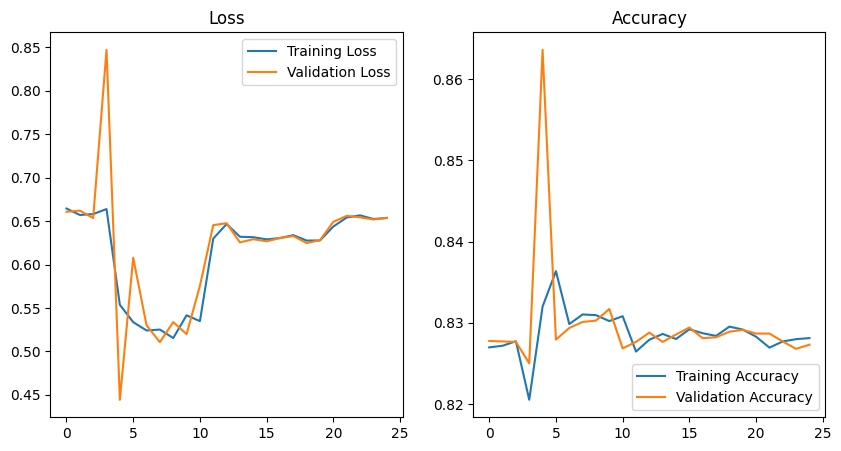

In [26]:
plot_graphs(train_accuracies, train_losses, val_accuracies, val_losses, mode="Validation")

## Long Short Term Memory (LSTM) Model

In [27]:
class LSTMModel(nn.Module):
    def __init__(self, inputSize, hiddenSize, numLayers, numClasses):
        super(LSTMModel, self).__init__()
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size = inputSize, 
                            hidden_size = hiddenSize, 
                            num_layers = numLayers, 
                            batch_first=True
                            )
        
        # Define a fully connected output layer
        self.fc = nn.Linear(hiddenSize, numClasses)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        
        # Forward propagate through LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Take the output from the last time step
        out = out[:, -1, :]
        
        # Pass through the fully connected layer
        out = self.fc(out)
        return out

In [28]:
# Instantiate model
lstm_model = LSTMModel(inputSize, hiddenSize, numLayers, numClasses)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)

In [29]:
train_loader, val_loader = get_dataloaders(X_train_new, X_val, y_train_new, y_val)
train_losses, train_accuracies, val_losses, val_accuracies = train_val(lstm_model, lstm_optimizer, train_loader, val_loader)

Epoch [1/25], Train Loss: 0.6648, Train Accuracy: 82.56%, Test Loss: 0.6474, Test Accuracy: 82.82%
Epoch [2/25], Train Loss: 0.6456, Train Accuracy: 82.80%, Test Loss: 0.6447, Test Accuracy: 82.69%
Epoch [3/25], Train Loss: 0.6387, Train Accuracy: 82.78%, Test Loss: 0.6337, Test Accuracy: 82.80%
Epoch [4/25], Train Loss: 0.5747, Train Accuracy: 82.90%, Test Loss: 0.5181, Test Accuracy: 84.70%
Epoch [5/25], Train Loss: 0.4855, Train Accuracy: 85.72%, Test Loss: 0.4419, Test Accuracy: 87.05%
Epoch [6/25], Train Loss: 0.4351, Train Accuracy: 88.30%, Test Loss: 0.3857, Test Accuracy: 90.46%
Epoch [7/25], Train Loss: 0.3912, Train Accuracy: 89.60%, Test Loss: 0.3596, Test Accuracy: 90.77%
Epoch [8/25], Train Loss: 0.4551, Train Accuracy: 87.08%, Test Loss: 0.6657, Test Accuracy: 78.32%
Epoch [9/25], Train Loss: 0.5329, Train Accuracy: 85.11%, Test Loss: 0.6580, Test Accuracy: 82.73%
Epoch [10/25], Train Loss: 0.6479, Train Accuracy: 82.80%, Test Loss: 0.6469, Test Accuracy: 82.71%
Epoch [11

In [30]:
# Save trained model
PATH = "./model/lstm_rnn_model.pth"
torch.save(lstm_model.state_dict(), PATH)

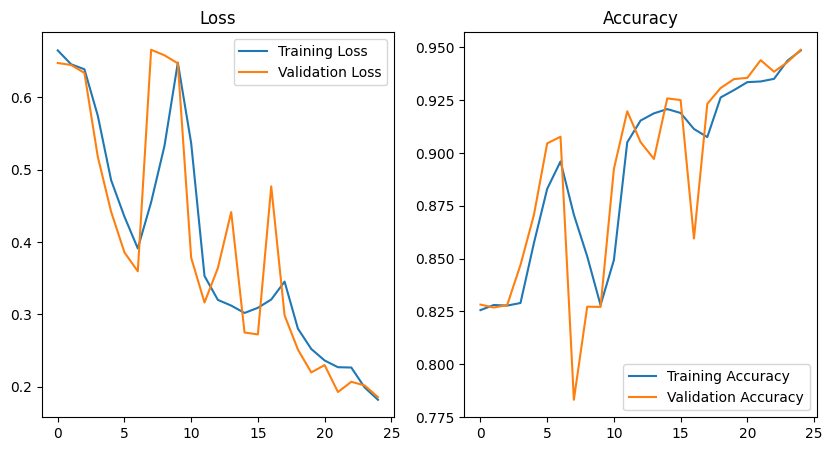

In [31]:
plot_graphs(train_accuracies, train_losses, val_accuracies, val_losses, mode="Validation")

## Gated Recurrent Unit (GRU)

In [32]:
class GRUModel(nn.Module):
    def __init__(self, inputSize, hiddenSize, numLayers, numClasses):
        super(GRUModel, self).__init__()
        
        # Define the GRU layer
        self.gru = nn.GRU(input_size=inputSize, 
                          hidden_size=hiddenSize, 
                          num_layers=numLayers, 
                          batch_first=True
                          )
        
        # Define a fully connected output layer
        self.fc = nn.Linear(hiddenSize, numClasses)
    
    def forward(self, x):
        # Initialize hidden state for GRU
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        
        # Forward propagate through GRU
        out, _ = self.gru(x, h0)
        
        # Take the output from the last time step
        out = out[:, -1, :]
        
        # Pass through the fully connected layer
        out = self.fc(out)
        return out

In [33]:
# Instantiate model
gru_model = GRUModel(inputSize, hiddenSize, numLayers, numClasses)
gru_optimizer = optim.Adam(gru_model.parameters(), lr=LEARNING_RATE)

In [34]:
train_loader, val_loader = get_dataloaders(X_train_new, X_val, y_train_new, y_val)
train_losses, train_accuracies, val_losses, val_accuracies = train_val(gru_model, gru_optimizer, train_loader, val_loader)

Epoch [1/25], Train Loss: 0.4995, Train Accuracy: 85.66%, Test Loss: 0.3775, Test Accuracy: 88.97%
Epoch [2/25], Train Loss: 0.3415, Train Accuracy: 90.76%, Test Loss: 0.3107, Test Accuracy: 91.73%
Epoch [3/25], Train Loss: 0.2948, Train Accuracy: 92.01%, Test Loss: 0.2711, Test Accuracy: 92.86%
Epoch [4/25], Train Loss: 0.2646, Train Accuracy: 92.87%, Test Loss: 0.2439, Test Accuracy: 93.56%
Epoch [5/25], Train Loss: 0.2454, Train Accuracy: 93.59%, Test Loss: 0.2368, Test Accuracy: 93.99%
Epoch [6/25], Train Loss: 0.2216, Train Accuracy: 94.25%, Test Loss: 0.2013, Test Accuracy: 94.65%
Epoch [7/25], Train Loss: 0.2052, Train Accuracy: 94.55%, Test Loss: 0.1928, Test Accuracy: 94.86%
Epoch [8/25], Train Loss: 0.1852, Train Accuracy: 95.02%, Test Loss: 0.1750, Test Accuracy: 95.05%
Epoch [9/25], Train Loss: 0.1711, Train Accuracy: 95.34%, Test Loss: 0.1694, Test Accuracy: 95.40%
Epoch [10/25], Train Loss: 0.1600, Train Accuracy: 95.64%, Test Loss: 0.1651, Test Accuracy: 95.41%
Epoch [11

In [35]:
# Save trained model
PATH = "./model/gru_rnn_model.pth"
torch.save(gru_model.state_dict(), PATH)

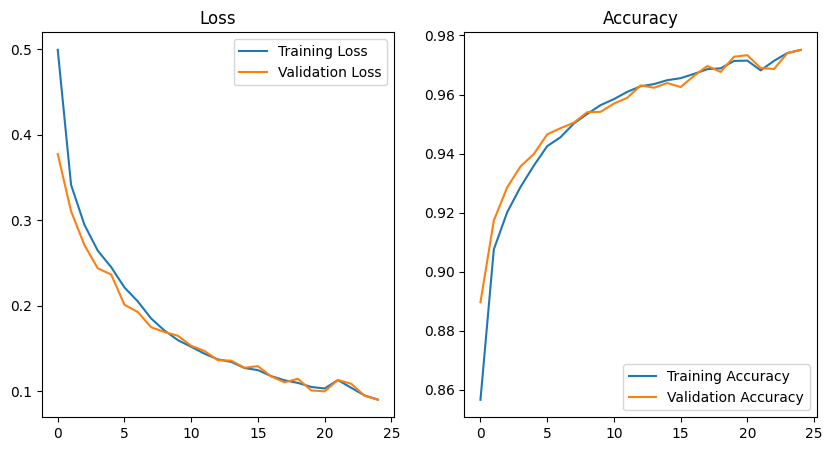

In [36]:
plot_graphs(train_accuracies, train_losses, val_accuracies, val_losses, mode="Validation")

## Testing best model on entire dataset

In [37]:
# Instantiate model
gru_model = GRUModel(inputSize, hiddenSize, numLayers, numClasses)
gru_optimizer = optim.Adam(gru_model.parameters(), lr=LEARNING_RATE)

train_loader, test_loader = get_dataloaders(X_train, X_test, y_train, y_test)
train_losses, train_accuracies, test_losses, test_accuracies = train_val(gru_model, gru_optimizer, train_loader, test_loader)

Epoch [1/25], Train Loss: 0.5252, Train Accuracy: 84.78%, Test Loss: 0.4127, Test Accuracy: 88.91%
Epoch [2/25], Train Loss: 0.3688, Train Accuracy: 89.65%, Test Loss: 0.3575, Test Accuracy: 89.94%
Epoch [3/25], Train Loss: 0.3062, Train Accuracy: 91.39%, Test Loss: 0.2815, Test Accuracy: 92.42%
Epoch [4/25], Train Loss: 0.2646, Train Accuracy: 93.06%, Test Loss: 0.2634, Test Accuracy: 93.19%
Epoch [5/25], Train Loss: 0.2445, Train Accuracy: 93.71%, Test Loss: 0.2391, Test Accuracy: 94.15%
Epoch [6/25], Train Loss: 0.2328, Train Accuracy: 94.05%, Test Loss: 0.2451, Test Accuracy: 93.50%
Epoch [7/25], Train Loss: 0.2147, Train Accuracy: 94.44%, Test Loss: 0.2183, Test Accuracy: 94.29%
Epoch [8/25], Train Loss: 0.2996, Train Accuracy: 92.02%, Test Loss: 0.2561, Test Accuracy: 93.15%
Epoch [9/25], Train Loss: 0.2405, Train Accuracy: 93.29%, Test Loss: 0.2139, Test Accuracy: 94.54%
Epoch [10/25], Train Loss: 0.1943, Train Accuracy: 94.62%, Test Loss: 0.1790, Test Accuracy: 95.20%
Epoch [11

In [38]:
# Save trained model
PATH = "./model/gru.pth"
torch.save(gru_model.state_dict(), PATH)

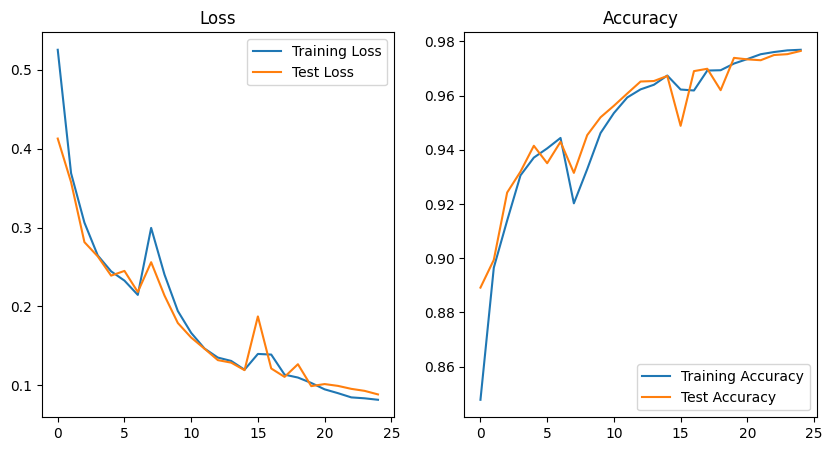

In [40]:
plot_graphs(train_accuracies, train_losses, test_accuracies, test_losses, mode="Test")